# Dengue fever: Cases in America over time
Data source: [PAHO (Pan American Health Organization - PLISA Health Information Plattform for the Americans)](https://www3.paho.org/data/index.php/en/mnu-topics/indicadores-dengue-en/dengue-nacional-en/254-dengue-incidencia-en.html)

In [1]:
# pip install geopandas
# pip install libpysal
# pip install mapclassify
# pip install Pillow

In [2]:
# Main data packages
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import mapclassify
from PIL import Image

## Preperation 
Load data, arrange and merge dataframes

In [3]:
# import data
cases_df = pd.read_csv('data/PAHO_cases_incidence.csv', sep=";")

# prepare the world map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [4]:
# set latitude and longitude values for both cities
cities = pd.DataFrame.from_dict({'San Juan': [18.451667, -66.068889], 
                                 'Iquitos': [-3.755147, -73.249111]}, 
                                orient='index', columns=['latitude', 'longitude'])

In [5]:
# convert column names to lower case
cols = cases_df.columns.tolist()
cols = [col.lower() for col in cols]
cases_df.columns = cols

# rename column names
cases_df.rename(columns={'total casos de dengue': 'cases'}, inplace=True)

# delete 'incidence per 100,000 pop.' as it is wrongly formated
cases_df = cases_df.drop(['incidence per 100,000 pop.'], axis=1)

# calculate incidence rate again (cases / 100.000 population)
cases_df['incidence'] = cases_df['cases']/(cases_df['population']/100000)

# replace certain country names in order to later match with world
cases_df['country_en'].replace(to_replace='Dominican Republic', value='Dominican Rep.', inplace=True)
cases_df['country_en'].replace(to_replace='French Guiana', value='France', inplace=True)

# merge cases_df with world to get geometry
cases_df_world = cases_df.merge(world, how ='left', left_on='country_en', right_on='name')

# drop unused features
cases_df_world = cases_df_world.drop(['pop_est', 'continent', 'name', 'gdp_md_est'], axis=1)

# drop rows in this dataframe which are not in the world map (does not have geometry)
cases_df_world.dropna(subset=['geometry'], inplace=True)

## Generate figures with incidence
Within a for-loop a plot is generated for each year

In [28]:
# get the years as ifentifier
years = cases_df_world['year'].unique().tolist()

# get empty list to store file names in
files = []

for year in years:
    # subset dataframe for each year and convert it to geodataframe
    df_plot = gpd.GeoDataFrame(cases_df_world[cases_df_world['year']==year])
    
    # create a figure
    fig, ax = plt.subplots(figsize=(10,15), tight_layout=True)

    # limit graph for america
    plt.ylim(ymax = 70, ymin = -60)
    plt.xlim(xmax = -33, xmin = -125)

    # plot world as background (to have also countries without cases)
    world.plot(color="lightgrey", ax=ax)

    # plot countries colored by the number of cases
    df_plot.plot(column='incidence', ax=ax, cmap='Reds', scheme='user_defined', 
                 classification_kwds={'bins':[1, 50, 100, 250, 500, 1000, 8000]}, # define classes
                 vmin=0, vmax=6, # to always have all classes used
                 legend=True,
                 legend_kwds={'title':'Incidence rate', 
                              'loc': 'lower left',
                              'fontsize': 20, 
                              'title_fontsize': 24, 
                              'labels': ['0', '1 - 50', '50 - 100', '100 - 250', '250 - 500', '500 - 1000', '1000 - 8000']}); # new labels for classes

    # add the two cities 
    cities.plot(x="longitude", y="latitude", kind="scatter", ax=ax, color='blue', s=50);
    for city in range(2):
        ax.text(x=cities.longitude[city]+2.5, y=cities.latitude[city]-0.75, s=cities.index[city], fontsize=20, color='blue')

    # add text with year 
    ax.text(x=-122.5, y=-25, s=f'{year}', fontsize=30);
    # add text with definition of incidence rate
    ax.text(x=-96, y=-58, s='Incidence rate = \n Total dengue cases / 100,000 population', fontsize=20);

    # prevent longitude and latitude axis
    ax.axis('off');
    
    # prevent show figure in notebook
    plt.close(fig)
    
    # get label to save and put it in list 
    file_name = 'plots/map_' + str(year) + '.png'
    files.append(file_name)
    
    # save the plot
    fig.savefig(file_name, dpi=150)

#### Save all figures in a GIF

In [29]:
# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html --> gif
img, *imgs = [Image.open(f) for f in files]
img.save(fp="plots/GIF_dengue_cases.gif", format='GIF', append_images=imgs,
         save_all=True, duration=500, loop=0, dpi=150)

## Plot the two cities on a map

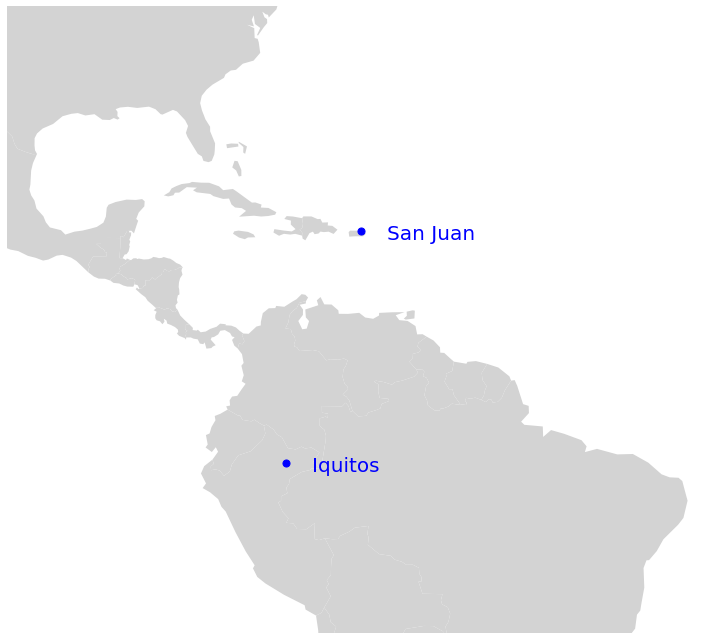

In [21]:
fig, ax = plt.subplots(figsize=(10,9), tight_layout=True)

# limit graph for america
plt.ylim(ymax = 40, ymin = -20)
plt.xlim(xmax = -33, xmin = -100)

# plot world as background (to have also countries without cases)
world.plot(color="lightgrey", ax=ax)

# prevent longitude and latitude axis
ax.axis('off')

# add the two cities with legend
cities.plot(x="longitude", y="latitude", kind="scatter", ax=ax, color='blue', s=50);
for city in range(2):
    ax.text(x=cities.longitude[city]+2.5, y=cities.latitude[city]-0.75, s=cities.index[city], fontsize=20, color='blue')

fig.savefig('plots/map_with_cities.png', dpi=300)